In [29]:
import numpy as np
import math
import random
import os
from datetime import datetime
import matplotlib.pyplot as plt
from multiprocessing import Process

In [139]:
file_euclidean = '../data/1000_euclideanDistance.txt'
file_random = '../data/1000_randomDistance.txt'
output_path = '../result/'
log_path = '../log/'

In [31]:
class TSP_Solver():
    def __init__(self, file_path, output_path, log_path):
        self.file_path = file_path
        self.distances, self.nodes=self.read_data(file_path)
        
        self.output_path = output_path
        self.log_path = log_path
        
        self.solver = 'NN'
        self.evaluate_iter=1000
        self.max_iter = 1000
        self.initial_temp = 1
        self.cooling_rate = 0.99999
        self.stopping_temp = 0.001
        self.init='random'
        self.best_length=-1.0
        self.best_path=[]
        self.result=()
        
        self.solve_name=''
        self.log_file_path = ''
        
        self.iter=self.max_iter
        
        self.print=1
        self.save=1
        self.log=1

    def read_data(self,file_path):
        distances = {}
        nodes = set()
        with open(file_path, 'r') as file:
            next(file)
            next(file)
            for line in file:
                node1, node2, distance = line.split()
                distances[(node1, node2)] = float(distance)
                distances[(node2, node1)] = float(distance) # 因为是对称的
                nodes.add(node1)
                nodes.add(node2)
        return distances, nodes

    def random_init(self):
        init_path = list(self.nodes)
        random.shuffle(init_path)
        return init_path   
    
    def NN_init(self):
        return self.nearest_neighbor_algorithm()[0]
    
    def calculate_path_length(self, path):
        length = 0
        for i in range(len(path) - 1):
            length += self.distances.get((path[i], path[i+1]), 0)
        if len(path) > 1:
            length += self.distances.get((path[-1], path[0]), 0)
        return length
    
    def nearest_neighbor_algorithm(self):
        current_node = np.random.choice(list(self.nodes))
        path = [current_node]
        remaining_nodes = set(self.nodes)
        remaining_nodes.remove(current_node)

        while remaining_nodes:
            next_node = min(remaining_nodes, key=lambda node: self.distances.get((current_node, node), float('inf')))
            path.append(next_node)
            remaining_nodes.remove(next_node)
            current_node = next_node
            
        length = self.calculate_path_length(path)
        
        return path , length
    
    def iter_NN(self):
        best_path, best_length = self.nearest_neighbor_algorithm()
        
        self.printf(f'0-iter-new_best_length: {best_length}')
        self._append_float_to_log(best_length)
        
        for i in range(self.max_iter-1):
            path , length = self.nearest_neighbor_algorithm()
            if length < best_length:
                best_path=path
                best_length=length

                self.printf(f'{i+1}-iter-new_best_length: {best_length}')
            self._append_float_to_log(best_length)
                
        return best_path, best_length
    
    def simulated_annealing(self,initial_path):
        current_path=initial_path
        current_length = self.calculate_path_length(current_path)
        
        best_path = current_path
        best_length = current_length
        
        self.printf('new_length: ',best_length)
        self._append_float_to_log(best_length)
        
        temperature = self.initial_temp
        
        while temperature > self.stopping_temp:
            i, j = random.sample(range(len(self.nodes)), 2)
            new_solution = list(current_path)
            new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
            
            new_length = self.calculate_path_length(new_solution)
            
            if new_length < current_length or random.random() < math.exp((current_length - new_length) / temperature):
                current_path = new_solution
                current_length = new_length
                
                if new_length < best_length:
                    best_path = list(current_path)
                    best_length = new_length
                    
                    self.printf('new_length: ',best_length)
                    
            temperature *= self.cooling_rate
            self._append_float_to_log(best_length)
            self.iter+=1
            
        return best_path, best_length
    
    def two_opt_swap(self, path, i, k):
        """Applies a 2-opt swap by reversing the path segment between i and k."""
        new_path = path[:i] + path[i:k+1][::-1] + path[k+1:]
        return new_path
    
    def simulated_annealing_2opt(self, initial_path):
        current_path = initial_path
        current_length = self.calculate_path_length(current_path)
        temperature = self.initial_temp
        
        self.printf('new_length: ',current_length)
        self._append_float_to_log(current_length)

        while temperature > self.stopping_temp:
            # Select two indices i and k to perform 2-opt swap, where i < k
            i, k = sorted(random.sample(range(1, len(current_path)-1), 2))
            new_path = self.two_opt_swap(current_path, i, k)
            new_length = self.calculate_path_length(new_path)

            # If the new path is shorter, or accept it with a certain probability if it's longer
            if new_length < current_length or random.random() < math.exp((current_length - new_length) / temperature):
                current_path = new_path
                current_length = new_length
                self.printf('new_length: ',current_length)

            temperature *= self.cooling_rate
            self._append_float_to_log(current_length)
            self.iter+=1

        return current_path, current_length
    
    def three_opt_swap(self, path, i, j, k):
        """Return the best path found by applying a 3-opt swap."""
        # Given a path and indices i, j, k, return the best path obtained by removing
        # edges (i, i+1), (j, j+1), and (k, k+1) and reconnecting the segments.
        segment_choices = [
            path[:i+1] + path[j:k+1][::-1] + path[i+1:j][::-1] + path[k+1:],
            path[:i+1] + path[j:k+1] + path[i+1:j] + path[k+1:],
            path[:i+1] + path[j:k+1] + path[i+1:j][::-1] + path[k+1:],
            path[:i+1] + path[j:k+1][::-1] + path[i+1:j] + path[k+1:],
            path[:i+1] + path[k:j:-1] + path[i:j] + path[k+1:],
        ]
        
        # Find the best path among the possible segment reconnections
        best_path = min(segment_choices, key=lambda p: calculate_path_length(p, self.distances))
        return best_path
    
    def simulated_annealing_3opt(self, initial_path):
        current_path = initial_path
        current_length = self.calculate_path_length(current_path)
        temperature = self.initial_temp
        
        self.printf('new_length: ',current_length)
        self._append_float_to_log(current_length)

        while temperature > self.stopping_temp:
            i, j, k = sorted(random.sample(range(1, len(current_path)-1), 3))
            new_path = self.three_opt_swap(current_path, i, j, k)
            new_length = self.calculate_path_length(new_path)

            if new_length < current_length or random.random() < math.exp((current_length - new_length) / temperature):
                current_path = new_path
                current_length = new_length
                
                self.printf('new_length: ',current_length)
            
            temperature *= self.cooling_rate
            self._append_float_to_log(current_length)
            self.iter+=1

        return current_path, current_length
    
    def generate_name(self):
        base_name = os.path.basename(self.file_path)
        base_name_without_ext = os.path.splitext(base_name)[0]
        if base_name_without_ext[5] == 'e':
            base_name_without_ext = 'eu'
        else:
            base_name_without_ext = 'ra'
        timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
        if self.solver != 'NN':
            file_name = f"{timestamp}_{base_name_without_ext}_{self.solver}_it={self.initial_temp}st={self.stopping_temp}cr={self.cooling_rate}init={self.init}"
        else:
            file_name = f"{timestamp}_{base_name_without_ext}_{self.solver}"
        return file_name
    
    def _generate_log_file(self):
        log_file_name = self.solve_name+'.log'
        log_file_path = os.path.join(self.log_path, log_file_name)
        try:
            with open(log_file_path, 'x') as file:
                pass
        except FileExistsError:
            print(f"File {log_file_path} already exists.")
        self.log_file_path=log_file_path
            
    def _append_float_to_log(self, number):
        if self.log:
            with open(self.log_file_path, 'a') as file:
                file.write(f"{number}\n")
                
    def printf(self, *args, **kwargs):
        if self.print:
            print(*args, **kwargs)
    
    def _save_result(self):
        output_file_name=f'{self.solve_name}_iter={self.iter}_len={int(self.best_length)}.txt'
        output_file_path = os.path.join(self.output_path, output_file_name)
        
        with open(output_file_path, 'w') as file:
            for item in self.best_path:
                file.write(f"{item} ")
            if self.best_path:
                file.write(f"{self.best_path[0]}")
        print(f"File written to {output_file_path}")
        
    def evaluate(self,file_path):
        with open(file_path, 'r') as file:
            content = file.read().rstrip()
            input_list = content.split(" ")
            path=[item for item in input_list if item]
            path=path[:-1]
        return self.calculate_path_length(path)
    
    def set_param(self, **kwargs):
        for key, value in kwargs.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                print(f"{key} is not an attribute of {self.__class__.__name__}")
        if self.solver!='NN':
            self.evaluate_iter=(math.log(self.stopping_temp) - math.log(self.initial_temp)) / math.log(self.cooling_rate)
            print(f'evaluate_iter = {self.evaluate_iter}')
    
    def solve(self,if_print=1,if_save_result=1,if_log=1):
        self.print=if_print
        self.save=if_save_result
        self.log=if_log
        
        self.solve_name=self.generate_name()
        
        if self.log:
            self._generate_log_file()
        
        if self.solver == 'NN':
            best_path , best_length = self.iter_NN()
            
        else:
            self.iter=0
            if self.init=='random':
                init_path = self.random_init()
                
            elif self.init=='NN':
                init_path = self.NN_init()

            if self.solver == 'SA':
                best_path, best_length = self.simulated_annealing(init_path)
                
            elif self.solver == 'SA-opt2':
                best_path , best_length = self.simulated_annealing_2opt(init_path)
                
            elif self.solver == 'SA-opt3':
                best_path , best_length = self.simulated_annealing_3opt(init_path)
            
        print("The approximate best path:", best_path)
        print("Length of the best path:", best_length)
        
        self.best_path=best_path
        self.best_length=best_length
        self.result=(best_length,best_path)
        
        if self.save:
            self._save_result()

In [128]:
class DataPlotter:
    def __init__(self):
        self.fig, self.ax = plt.subplots(figsize=(10, 6))
    
    def add_curve(self, file_path, alpha=(1,0.2,1)):
        base_name = os.path.basename(file_path)
        if 'NN' in base_name and 'SA' not in base_name:
            color = 'blue'
            alpha = alpha[0]
            label='NN'
        elif 'SA-opt2' in base_name:
            color = 'orange'
            alpha = alpha[1]
            label='SA-opt2'
        elif 'SA-opt3' in base_name:
            color = 'red'
            alpha = alpha[2]
            label='SA-opt3'
        else:
            print("File name does not specify a recognized solver.")
            return
        
        if 'init=NN' in base_name:
            linestyle = '--'
            label+='-init=NN'
        else:
            linestyle = '-'
            if 'NN' not in base_name:
                label+='-init=random'

        with open(file_path, 'r') as file:
            lines = file.readlines()
            data = [float(line.strip()) for line in lines]
            
        self.ax.plot(data, color=color, linestyle=linestyle, label=label, alpha=alpha)
    
    def show(self, xlim=(), ylog=0, xlog=0, title="Data Visualization"):

        self.ax.set_title(title)
        self.ax.set_xlabel("Iteration")
        self.ax.set_ylabel("Path Length")
        
        if xlim!=():
            self.ax.set_xlim(xlim)
            
        if ylog==1:
            self.ax.set_yscale('log')
            
        if xlog==1:
            self.ax.set_xscale('log')
        
        handles, labels = self.ax.get_legend_handles_labels()

        unique_labels = []
        unique_handles = []
        for handle, label in zip(handles, labels):
            if label not in unique_labels:
                unique_labels.append(label)
                unique_handles.append(handle)

        self.ax.legend(unique_handles, unique_labels)

        plt.show()

In [87]:
es=TSP_Solver(file_euclidean, output_path, log_path)

In [187]:
es.set_param(solver='SA-opt3', initial_temp=1, cooling_rate=0.999, stopping_temp=0.001, init='random')
es.solve(if_print=1,if_save_result=1,if_log=1)

new_length:  50767.039999999964
new_length:  50726.580000000016
new_length:  50679.67000000006
new_length:  50638.79000000006
new_length:  50550.88000000006
new_length:  50473.96000000008
new_length:  50358.920000000035
new_length:  50336.67000000005
new_length:  50253.080000000045
new_length:  50225.26999999999
new_length:  50200.85999999999
new_length:  50170.56
new_length:  50150.56000000003
new_length:  50078.35000000001
new_length:  50049.68000000002
new_length:  49957.01000000008
new_length:  49859.90000000001
new_length:  49857.34000000007
new_length:  49842.19999999999
new_length:  49782.78999999999
new_length:  49675.97000000003
new_length:  49653.29000000003
new_length:  49617.94000000007
new_length:  49568.84000000005
new_length:  49507.46000000008
new_length:  49497.950000000026
new_length:  49476.80000000003
new_length:  49418.94000000001
new_length:  49326.92000000001
new_length:  49220.180000000015
new_length:  49208.90999999998
new_length:  49179.34999999998
new_length:

In [196]:
es.set_param(solver='NN', max_iter=100)
es.solve(if_print=1,if_save_result=1,if_log=1)

0-iter-new_best_length: 2918.3000000000006
19-iter-new_best_length: 2847.4800000000014
85-iter-new_best_length: 2824.4999999999995
The approximate best path: ['180', '91', '795', '747', '964', '322', '329', '668', '513', '529', '15', '12', '741', '829', '68', '396', '85', '769', '568', '9', '812', '198', '454', '702', '444', '802', '814', '510', '27', '907', '243', '711', '525', '526', '900', '500', '496', '44', '380', '148', '128', '753', '911', '931', '822', '998', '498', '502', '936', '530', '616', '855', '420', '582', '595', '636', '521', '140', '16', '179', '704', '118', '507', '271', '323', '320', '46', '535', '321', '257', '809', '457', '889', '774', '218', '446', '992', '359', '519', '973', '966', '816', '275', '389', '20', '239', '881', '365', '86', '212', '1000', '407', '33', '385', '662', '633', '926', '10', '640', '401', '466', '967', '539', '550', '362', '433', '395', '950', '714', '222', '80', '664', '314', '885', '157', '929', '245', '553', '516', '703', '887', '328', '1

In [200]:
es.set_param(solver='SA-opt3', initial_temp=1, cooling_rate=0.999, stopping_temp=0.001, init='NN')
es.solve(if_print=1,if_save_result=1,if_log=1)

evaluate_iter = 6904.300825408361
new_length:  2917.3600000000024
new_length:  2917.3600000000024
new_length:  2915.190000000003
new_length:  2914.890000000003
new_length:  2914.890000000003
new_length:  2914.890000000003
new_length:  2914.890000000003
new_length:  2914.890000000003
new_length:  2914.890000000003
new_length:  2914.4700000000025
new_length:  2914.4700000000025
new_length:  2914.4700000000025
new_length:  2914.4700000000025
new_length:  2914.4700000000025
new_length:  2914.539999999999
new_length:  2914.539999999999
new_length:  2914.539999999999
new_length:  2914.539999999999
new_length:  2914.539999999999
new_length:  2914.539999999999
new_length:  2913.289999999999
new_length:  2909.360000000001
new_length:  2909.360000000001
new_length:  2909.360000000001
new_length:  2909.360000000001
new_length:  2907.9200000000005
new_length:  2907.9200000000005
new_length:  2906.390000000001
new_length:  2906.390000000001
new_length:  2906.390000000001
new_length:  2906.390000000

In [218]:
for i in range(9):
    es.set_param(solver='SA-opt2', initial_temp=1, cooling_rate=0.999, stopping_temp=0.001, init='random')
    es.solve(if_print=1,if_save_result=1,if_log=1)

evaluate_iter = 6904.300825408361
new_length:  51147.769999999975
new_length:  51124.30000000003
new_length:  51119.190000000024
new_length:  51049.70000000001
new_length:  51026.680000000015
new_length:  50984.37000000002
new_length:  50982.85000000001
new_length:  50983.750000000015
new_length:  50944.37000000001
new_length:  50926.23000000001
new_length:  50912.66
new_length:  50870.26999999994
new_length:  50802.10999999997
new_length:  50794.16999999994
new_length:  50741.509999999944
new_length:  50700.06999999994
new_length:  50674.53999999994
new_length:  50654.91999999995
new_length:  50654.85999999994
new_length:  50648.02000000001
new_length:  50640.95000000003
new_length:  50620.650000000016
new_length:  50592.05
new_length:  50556.49
new_length:  50546.56
new_length:  50527.030000000006
new_length:  50523.29999999998
new_length:  50515.72999999998
new_length:  50434.68999999997
new_length:  50430.140000000014
new_length:  50413.750000000015
new_length:  50394.49000000001
n

In [140]:
es.set_param(solver='SA-opt2', initial_temp=10, cooling_rate=0.99999, stopping_temp=0.001, init='random')
es.solve(if_print=1,if_save_result=1,if_log=1)

evaluate_iter = 921029.4320239488
new_length:  51574.620000000024
new_length:  51502.49999999997
new_length:  51431.15999999999
new_length:  51438.58000000002
new_length:  51426.550000000025
new_length:  51425.53000000002
new_length:  51420.420000000006
new_length:  51428.420000000006
new_length:  51422.849999999984
new_length:  51299.76000000001
new_length:  51266.44
new_length:  51261.74
new_length:  51268.329999999994
new_length:  51273.63000000004
new_length:  51256.88000000006
new_length:  51224.62000000005
new_length:  51229.33000000004
new_length:  51227.100000000035
new_length:  51201.30000000005
new_length:  51165.58000000004
new_length:  51148.76000000006
new_length:  51123.03000000007
new_length:  51108.100000000035
new_length:  51111.20000000001
new_length:  51060.56000000002
new_length:  51022.729999999996
new_length:  51027.96000000009
new_length:  51005.69000000008
new_length:  50946.300000000076
new_length:  50932.19000000005
new_length:  50944.60000000007
new_length:  

In [25]:
rs=TSP_Solver(file_random, output_path, log_path)

In [235]:
rs.set_param(solver='NN', max_iter=100)
rs.solve(if_print=1,if_save_result=1,if_log=1)

0-iter-new_best_length: 642.4500000000002
5-iter-new_best_length: 573.6200000000003
The approximate best path: ['944', '677', '515', '302', '636', '840', '491', '565', '80', '134', '906', '799', '586', '149', '716', '333', '365', '349', '81', '552', '85', '609', '142', '440', '325', '72', '882', '788', '757', '729', '693', '567', '774', '231', '640', '654', '659', '633', '529', '283', '998', '741', '263', '538', '469', '138', '679', '412', '521', '418', '501', '561', '241', '938', '401', '510', '216', '725', '872', '40', '901', '204', '207', '598', '382', '506', '320', '994', '628', '7', '391', '793', '605', '920', '698', '277', '685', '898', '588', '864', '403', '945', '29', '458', '824', '470', '233', '519', '296', '969', '26', '377', '199', '392', '896', '731', '2', '986', '489', '680', '21', '919', '276', '761', '902', '578', '608', '853', '175', '935', '581', '186', '457', '36', '289', '785', '862', '955', '485', '110', '83', '810', '505', '332', '664', '92', '182', '900', '348', 

In [236]:
rs.set_param(solver='SA-opt2', initial_temp=1, cooling_rate=0.999, stopping_temp=0.001, init='random')
rs.solve(if_print=1,if_save_result=1,if_log=1)

evaluate_iter = 6904.300825408361
new_length:  49321.28999999996
new_length:  49234.06999999997
new_length:  49193.639999999985
new_length:  49062.03999999997
new_length:  49016.67999999997
new_length:  48984.899999999965
new_length:  48977.12000000003
new_length:  48947.94000000004
new_length:  48940.61000000004
new_length:  48826.21000000003
new_length:  48745.700000000026
new_length:  48724.840000000026
new_length:  48679.74999999996
new_length:  48607.22999999994
new_length:  48579.72999999994
new_length:  48562.20999999994
new_length:  48554.020000000055
new_length:  48536.73999999998
new_length:  48463.179999999986
new_length:  48448.340000000004
new_length:  48450.97000000001
new_length:  48409.98000000001
new_length:  48405.01
new_length:  48388.12000000001
new_length:  48356.85000000003
new_length:  48327.880000000056
new_length:  48309.94000000006
new_length:  48273.850000000064
new_length:  48241.680000000066
new_length:  48183.69000000006
new_length:  48118.56000000002
new_

In [237]:
rs.set_param(solver='SA-opt3', initial_temp=1, cooling_rate=0.999, stopping_temp=0.001, init='random')
rs.solve(if_print=1,if_save_result=1,if_log=1)

evaluate_iter = 6904.300825408361
new_length:  50219.31000000003
new_length:  50072.85000000003
new_length:  50002.51000000003
new_length:  49882.09000000003
new_length:  49781.05
new_length:  49686.969999999994
new_length:  49633.46000000006
new_length:  49568.19000000004
new_length:  49552.880000000056
new_length:  49547.88000000002
new_length:  49526.30000000001
new_length:  49470.409999999996
new_length:  49379.28000000006
new_length:  49316.760000000024
new_length:  49304.95999999999
new_length:  49291.59
new_length:  49242.23
new_length:  49172.73
new_length:  49135.370000000024
new_length:  48979.63000000001
new_length:  48903.14000000002
new_length:  48840.03000000003
new_length:  48757.729999999996
new_length:  48664.84999999999
new_length:  48613.07
new_length:  48581.43000000002
new_length:  48550.20000000003
new_length:  48498.97000000003
new_length:  48351.10000000003
new_length:  48349.35000000006
new_length:  48226.16000000003
new_length:  48192.08000000008
new_length:  

In [258]:
rs.set_param(solver='SA-opt3', initial_temp=1, cooling_rate=0.999, stopping_temp=0.001, init='NN')
rs.solve(if_print=1,if_save_result=1,if_log=1)

evaluate_iter = 6904.300825408361
new_length:  654.6100000000001
new_length:  630.7199999999985
new_length:  630.7199999999985
new_length:  630.7199999999985
new_length:  630.7199999999985
new_length:  630.7199999999985
new_length:  630.7199999999985
new_length:  630.7199999999985
new_length:  623.4399999999981
new_length:  623.4399999999981
new_length:  623.4399999999981
new_length:  622.2499999999993
new_length:  622.2499999999993
new_length:  622.2499999999993
new_length:  622.2499999999993
new_length:  622.2499999999993
new_length:  614.2599999999992
new_length:  614.2599999999992
new_length:  592.1499999999993
new_length:  592.1499999999993
new_length:  585.1799999999992
new_length:  585.1799999999992
new_length:  585.1799999999992
new_length:  585.1799999999992
new_length:  585.1799999999992
new_length:  585.1799999999992
new_length:  585.1799999999992
new_length:  585.1799999999992
new_length:  585.1799999999992
new_length:  585.1799999999992
new_length:  585.1799999999992
new_l

In [27]:
rs.set_param(solver='SA-opt2', initial_temp=10, cooling_rate=0.99999, stopping_temp=0.001, init='random')
rs.solve(if_print=1,if_save_result=1,if_log=1)

evaluate_iter = 921029.4320239488
new_length:  50502.43999999997
new_length:  50462.609999999986
new_length:  50445.51999999999
new_length:  50368.42999999998
new_length:  50274.46999999998
new_length:  50260.15999999997
new_length:  50187.26999999997
new_length:  50184.610000000015
new_length:  50065.68000000002
new_length:  50077.46000000002
new_length:  50075.91000000002
new_length:  50071.919999999984
new_length:  49990.80999999997
new_length:  49954.079999999994
new_length:  49895.27999999999
new_length:  49814.78999999999
new_length:  49808.909999999996
new_length:  49740.88000000003
new_length:  49663.660000000025
new_length:  49659.000000000044
new_length:  49634.21
new_length:  49610.04
new_length:  49581.939999999915
new_length:  49573.56999999997
new_length:  49566.679999999964
new_length:  49536.86999999996
new_length:  49462.16999999999
new_length:  49464.64999999999
new_length:  49405.93000000001
new_length:  49368.98
new_length:  49346.340000000004
new_length:  49332.020

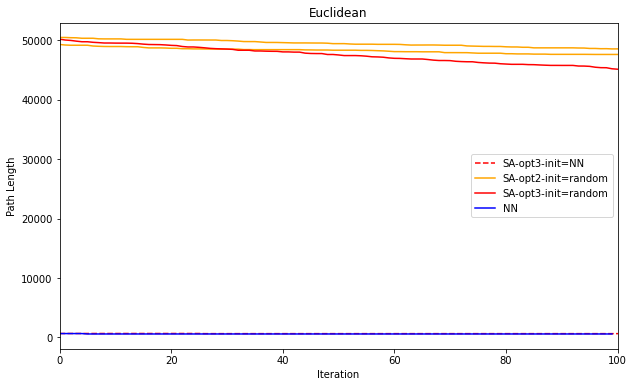

In [138]:
plotter = DataPlotter()
log_files = [file for file in os.listdir(log_path) if os.path.isfile(os.path.join(log_path, file))]
for log_file in log_files:
    if '_ra' in log_file:
        plotter.add_curve(log_path+log_file,alpha=(1,1,1))
plotter.show(xlim=(0,100),title='Euclidean')

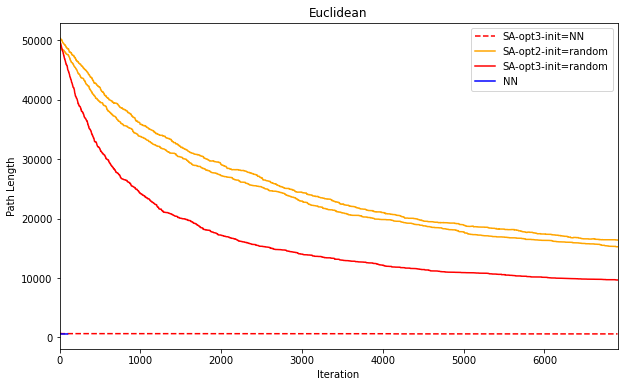

In [137]:
plotter = DataPlotter()
log_files = [file for file in os.listdir(log_path) if os.path.isfile(os.path.join(log_path, file))]
for log_file in log_files:
    if '_ra' in log_file:
        plotter.add_curve(log_path+log_file,alpha=(1,1,1))
plotter.show(xlim=(0,6905),title='Euclidean')
plt.show()

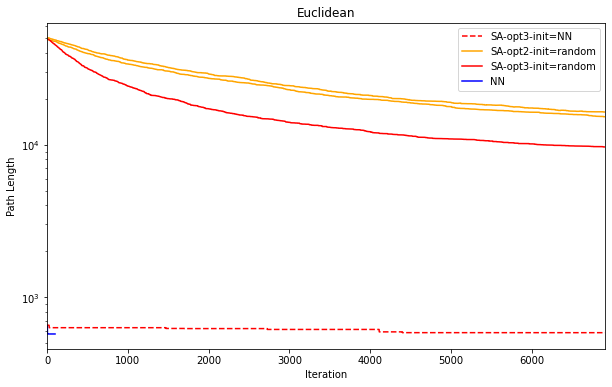

In [136]:
plotter = DataPlotter()
log_files = [file for file in os.listdir(log_path) if os.path.isfile(os.path.join(log_path, file))]
for log_file in log_files:
    if '_ra' in log_file:
        plotter.add_curve(log_path+log_file,alpha=(1,1,1))
plotter.show(xlim=(0,6905),ylog=1,title='Euclidean')
plt.show()

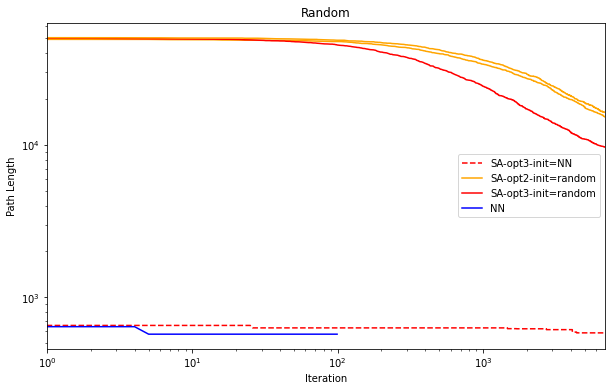

In [135]:
plotter = DataPlotter()
log_files = [file for file in os.listdir(log_path) if os.path.isfile(os.path.join(log_path, file))]
for log_file in log_files:
    if '_ra' in log_file:
        plotter.add_curve(log_path+log_file,alpha=(1,1,1))
plotter.show(xlim=(1,6905), ylog=1, xlog=1, title='Random')
plt.show()

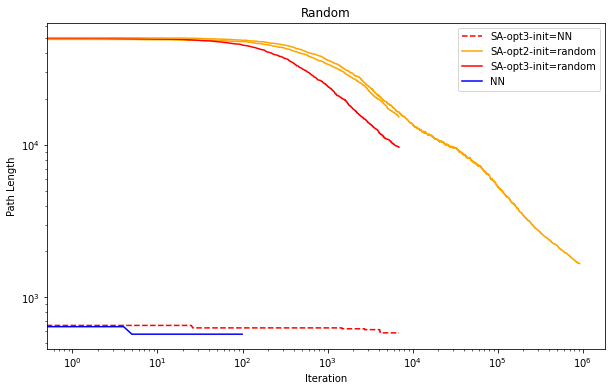

In [133]:
plotter = DataPlotter()
log_files = [file for file in os.listdir(log_path) if os.path.isfile(os.path.join(log_path, file))]
for log_file in log_files:
    if '_ra' in log_file:
        plotter.add_curve(log_path+log_file,alpha=(1,1,1))
plotter.show(ylog=1, xlog=1,title='Random')
plt.show()

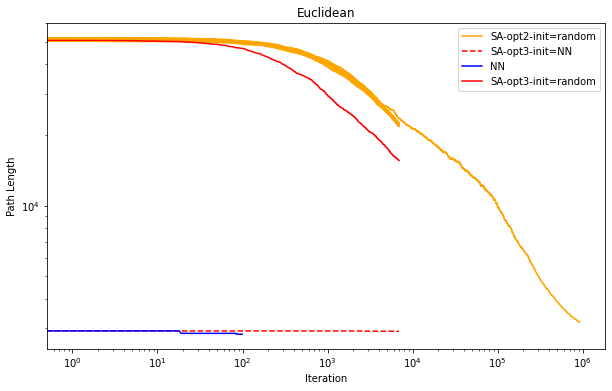

In [141]:
plotter = DataPlotter()
log_files = [file for file in os.listdir(log_path) if os.path.isfile(os.path.join(log_path, file))]
for log_file in log_files:
    if '_eu' in log_file:
        plotter.add_curve(log_path+log_file,alpha=(1,1,1))
plotter.show(xlog=1,ylog=1,title='Euclidean')